In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, datetime, DataFrame, concat
from pandas.plotting import autocorrelation_plot
from matplotlib import pyplot
from numpy import asarray
from sklearn.metrics import mean_absolute_error, mean_squared_error 
from sklearn.ensemble import RandomForestRegressor

/var/folders/pt/xwz928fd2l973b6cv37cynzc0000gn/T/ipykernel_18282/2818967433.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import read_csv, datetime, DataFrame, concat


In [14]:
df_cases = pd.read_csv("Cases.csv", encoding= 'unicode_escape')
df_deaths = pd.read_csv("Deaths.csv", encoding= 'unicode_escape')

In [15]:
# clean cases data and convert them to numeric
df_cases = df_cases.applymap(lambda x: x.strip())
df_cases = df_cases.applymap(lambda x: x.replace(",", ""))
df_cases = df_cases.applymap(lambda x: x.replace("..", ""))

cols = df_cases.columns[1:]
for col in cols:
    df_cases[col] = pd.to_numeric(df_cases[col],errors='coerce')

df_cases = df_cases.fillna(0)

In [16]:
df_deaths = df_deaths.fillna(0)

p-value: 0.000000


<AxesSubplot:>

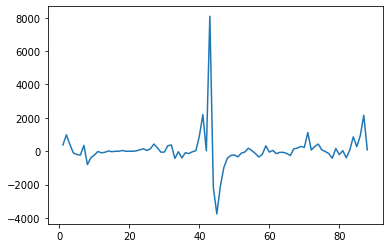

In [213]:
# df_cases["Dublin_diff_1"] = df_cases["Dublin"].diff(periods=1)
# df_cases['Dublin_diff_1']
# from statsmodels.tsa.stattools import adfuller
# result = adfuller(df_cases['Dublin_diff_1'].dropna())
# print('p-value: %f' % result[1])

# df_cases['Dublin_diff_1'].plot()

In [ ]:
df_cases.describe()

In [ ]:
df_deaths.describe()

<AxesSubplot:>

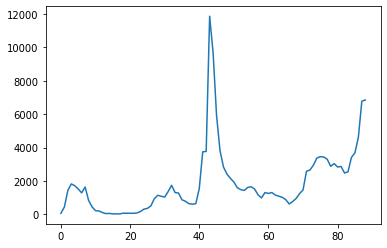

In [22]:
df_cases['Dublin'].plot()

In [144]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test, :], data[-n_test:, :]
 
# fit an random forest model and make a one step prediction
def random_forest_forecast(train, testX, n_estimators=1000):
    # transform list into array
    train = asarray(train)
    # split into input and output columns
    trainX, trainy = train[:, :-1], train[:, -1]
    # fit model
    model = RandomForestRegressor(n_estimators=n_estimators)
    model.fit(trainX, trainy)
    # make a one-step prediction
    yhat = model.predict([testX])
    return yhat[0]
 
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, n_est):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
        # fit model on history and make a prediction
        yhat = random_forest_forecast(history, testX, n_est)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
        # summarize progress
        # print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
    
    # estimate prediction error
    error = mean_absolute_error(test[:, -1], predictions)
    rmse = mean_squared_error(test[:, -1], predictions,squared=False)
    return error,rmse, test[:, -1], predictions

>expected=3303.0, predicted=3974.3
>expected=2884.0, predicted=3439.1
>expected=3045.0, predicted=2773.5
>expected=2841.0, predicted=3198.6
>expected=2874.0, predicted=2920.9
>expected=2482.0, predicted=2968.1
>expected=2553.0, predicted=2400.1
>expected=3415.0, predicted=2635.3
>expected=3687.0, predicted=3419.9
>expected=4619.0, predicted=5053.2
>expected=6776.0, predicted=6819.0
>expected=6856.0, predicted=7327.1
RMSE: 439.105


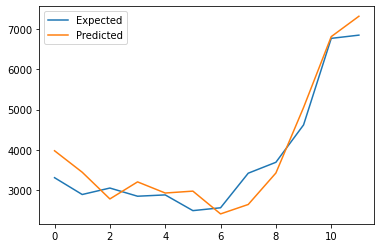

In [219]:
# dublin
weeks_test = 12
last_weeks_input = 3

data = series_to_supervised(df_cases[['Dublin']].values, n_in=last_weeks_input)

# evaluate
mae,rmse, y, yhat = walk_forward_validation(data, weeks_test, n_est=2000)
print('RMSE: %.3f' % rmse)
# plot expected vs predicted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()

>expected=119.0, predicted=262.9
>expected=123.0, predicted=175.9
>expected=134.0, predicted=137.8
>expected=136.0, predicted=135.2
>expected=142.0, predicted=127.6
>expected=157.0, predicted=136.0
>expected=188.0, predicted=149.1
>expected=174.0, predicted=165.0
>expected=304.0, predicted=173.3
>expected=254.0, predicted=222.5
>expected=398.0, predicted=205.1
>expected=381.0, predicted=267.7
>expected=384.0, predicted=274.5
>expected=257.0, predicted=218.3
>expected=191.0, predicted=143.9
>expected=175.0, predicted=160.7
>expected=181.0, predicted=212.9
>expected=193.0, predicted=246.5
>expected=160.0, predicted=207.2
>expected=158.0, predicted=174.7
>expected=239.0, predicted=201.4
>expected=252.0, predicted=279.5
>expected=346.0, predicted=240.0
>expected=420.0, predicted=253.4
>expected=171.0, predicted=139.9
>expected=245.0, predicted=168.0
>expected=147.0, predicted=299.6
>expected=174.0, predicted=281.1
>expected=149.0, predicted=144.0
>expected=221.0, predicted=182.2
>expected=

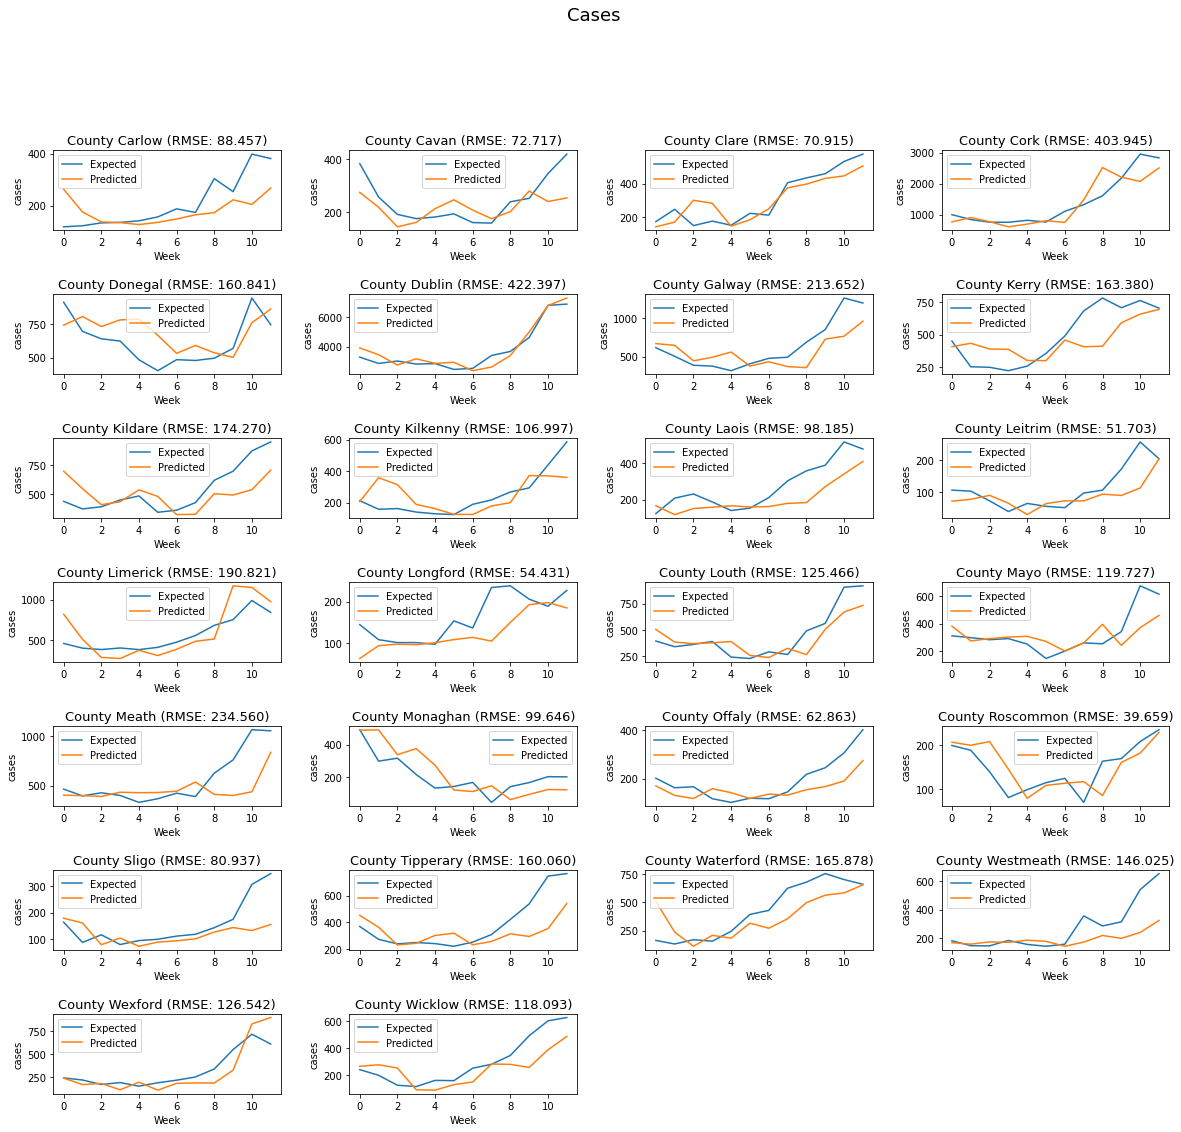

In [191]:
# all counties
weeks_test = 12
last_weeks_input = 3

figure = plt.gcf()
figure.set_size_inches(20, 20)
figure.suptitle('Cases', fontsize=18)
plt.rcParams['figure.constrained_layout.use'] = False

for idx, county in enumerate(df_cases.columns[1:]):
    data = series_to_supervised(df_cases[[county]].values, n_in=last_weeks_input)

    # evaluate
    mae,rmse, y, yhat = walk_forward_validation(data, weeks_test, n_est=2000)
    
    ax = figure.add_subplot(8, 4, idx+1)
    plt.title("County " + county + (' (RMSE: %.3f)' % rmse), fontsize=13)
    plt.subplots_adjust(wspace = 0.3, hspace= 0.8)
    ax.plot(y, label='Expected')
    ax.plot(yhat, label='Predicted')
    ax.legend()
    ax.set_xlabel('Week'); ax.set_ylabel('cases')

pyplot.show()

In [197]:
data = series_to_supervised(df_cases[['Dublin']].values, n_in=last_weeks_input)
# split into input and output columns

trainX, trainy = data[:, :-1], data[:, -1]

# fit model
model = RandomForestRegressor(n_estimators=2000)
model.fit(trainX, trainy)


# construct an input for a new prediction
row = df_cases[['Dublin']].values[-last_weeks_input:].flatten()


print(row)
for i in range(4):
    yhat = model.predict(asarray([row]))
    print('Input: %s, Predicted: %.3f' % (row, yhat[0]))
    row = np.append(row, round(yhat[0]))
    row = np.delete(row, 0)

[4619 6776 6856]
Input: [4619 6776 6856], Predicted: 6285.597
Input: [6776 6856 6286], Predicted: 5028.285
Input: [6856 6286 5028], Predicted: 5091.600
Input: [6286 5028 5092], Predicted: 5974.126


In [ ]:
# training output to predict next
# df_inc = df_cases[['Dublin']].copy()

# # make a 4 week prediction
# for i in range(4):
#     # print(df_inc)
#     train = series_to_supervised(df_inc.values, n_in=last_weeks_input)
#     # print(train)
    
#     # split into input and output columns
#     trainX, trainy = train[:, :-1], train[:, -1]

#     # fit model
#     model = RandomForestRegressor(n_estimators=2000)
#     model.fit(trainX, trainy)

#     # construct an input for a new prediction
#     row = df_inc.values[-last_weeks_input:].flatten()
    
#     yhat = model.predict(asarray([row]))
#     print('Input: %s, Predicted: %.3f' % (row, yhat[0]))
#     new_row = {'Dublin':round(yhat[0])}
#     #append row to the dataframe
#     df_inc = df_inc.append(new_row, ignore_index=True)
#     print(df_inc)
    